In [6]:
!pip install pyspark==3.5.0 delta-spark==3.1.0 --quiet


In [7]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()



Dataset Creation

In [10]:
# Path for storing Delta table
delta_path = "/tmp/orders_delta"

# Create sample DataFrame
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing",    1,  50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing",    3, 150),
]
cols = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, cols)

# Save as Delta table
df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(delta_path)

df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



Managed vs Unmanaged Tables

In [11]:
# Managed table
spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql(f"""
CREATE TABLE orders_managed
USING DELTA
LOCATION '{delta_path}'
""")

# Unmanaged table (points to same location)
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")
spark.sql(f"""
CREATE TABLE orders_unmanaged
USING DELTA
LOCATION '{delta_path}'
""")

spark.sql("SELECT * FROM orders_managed").show()
spark.sql("SELECT * FROM orders_unmanaged").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



Managed vs Unmanaged Tables

```
# This is formatted as code
```



3) CRUD Operations

In [12]:
from delta.tables import DeltaTable

delta = DeltaTable.forPath(spark, delta_path)

# UPDATE
delta.update("category = 'Clothing'", {"amount": "amount + 20"})

# DELETE
delta.delete("quantity < 2")

# MERGE
new_data = [
    (3, "Mike", "Electronics", 4, 650),
    (5, "Emma", "Furniture",   1, 200),
]
new_df = spark.createDataFrame(new_data, cols)
(delta.alias("t")
 .merge(new_df.alias("s"), "t.order_id = s.order_id")
 .whenMatchedUpdateAll()
 .whenNotMatchedInsertAll()
 .execute())

delta.toDF().show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|  Furniture|       1|   200|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



3) History & Time Travel

In [14]:
# Show table history
delta.history().show()

# Read from first version with data (version 1)
v1 = spark.read.format("delta").option("versionAsOf", 1).load(delta_path)
print("Version 1:")
v1.show()

# Read latest version
latest = spark.read.format("delta").load(delta_path)
print("Latest:")
latest.show()



+-------+--------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|   operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      4|2025-08-14 08:56:...|  NULL|    NULL|       MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          3|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      3|2025-08-14 08:56:...|  NULL|    NULL|      DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|          2|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5.

4) Incremental Load

In [15]:
# Mini-batch
batch = [
    (6, "Liam", "Electronics", 2, 500),
    (7, "Olivia", "Clothing",  5, 400),
]
batch_df = spark.createDataFrame(batch, cols)

# Append
batch_df.write.format("delta").mode("append").save(delta_path)

spark.read.format("delta").load(delta_path).show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|  Furniture|       1|   200|
|       6|         Liam|Electronics|       2|   500|
|       1|         John|Electronics|       2|   300|
|       7|       Olivia|   Clothing|       5|   400|
+--------+-------------+-----------+--------+------+



5) Simple Streaming Read

In [21]:
# Start streaming into memory
query = (spark.readStream.format("delta").load(delta_path)
         .writeStream
         .format("memory")    # keep results in memory
         .queryName("orders_stream")
         .outputMode("append")
         .start())



In [22]:
import time

for _ in range(5):
    spark.sql("SELECT * FROM orders_stream").show()
    time.sleep(5)  # wait between checks


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|  Furniture|       1|   200|
|       1|         John|Electronics|       2|   300|
|       6|         Liam|Electronics|       2|   500|
|       7|       Olivia|   Clothing|       5|   400|
|       8|         Noah|     Sports|       3|   300|
|       9|          Ava|      Books|       2|   120|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|  Furniture|       1|   200|
|       1|         John|Electronics|       2|

6) Visualization

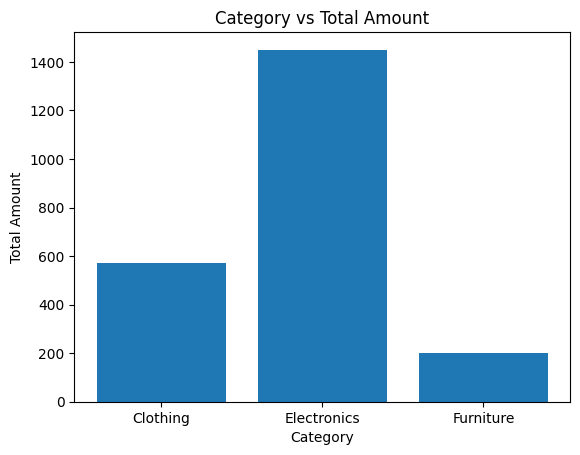

In [17]:
import matplotlib.pyplot as plt

pdf = spark.read.format("delta").load(delta_path).toPandas()
category_totals = pdf.groupby("category")["amount"].sum().reset_index()

plt.bar(category_totals["category"], category_totals["amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
